In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
new_saver = tf.train.import_meta_graph('../models/feb-13/5-58-4/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/feb-13/5-58-4/'))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/feb-13/5-56-4/model


In [4]:
# setup function to reproject coordinates
EPSG = CRS.WGS84
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
        

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    print(after)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


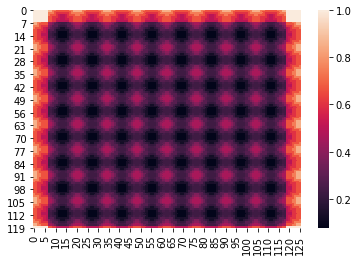

In [5]:
arr = np.array([[1, 1, 2, 2, 3, 3, 3],
                [1, 1, 2, 3, 3, 3, 3],
                [2, 2, 2, 3, 4, 4, 4],
                [2, 3, 3, 3, 4, 5, 6],
                [3, 3, 4, 4, 4, 5, 6],
                [3, 3, 4, 4, 5, 5, 6], 
                [3, 3, 4, 4, 6, 6, 6]])

#arr = np.array(
#      [[0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 1, 1, 1, 1, 1],
#       [0, 1, 2, 2, 2, 2, 2],
#       [0, 1, 2, 3, 3, 3, 3],
#       [0, 1, 2, 3, 4, 4, 4],
#       [0, 1, 2, 3, 4, 5, 5], 
#       [0, 1, 2, 3, 4, 5, 6]])

arr = arr / 6


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)



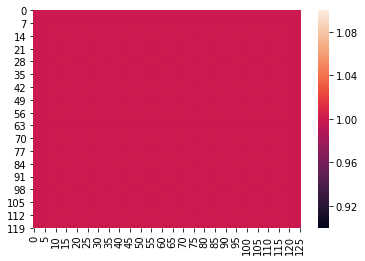

In [6]:
sum_filter = (upright + normal+right_filter + up_filter)# + right_filter + up_filter)
sns.heatmap(sum_filter)

In [7]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
min_all = [0.020395646858960392,
 0.03833778686821461,
 0.022913980782032013,
 0.08838867269456387,
 0.05731564749032259,
 0.0796274145692587,
 0.08639285631477833,
 0.08918419919908048,
 0.07416137464344502,
 0.04398707151412964,
 0.0,
 0.008659180235117674,
 -0.0134716229327023,
 0.006902076792903247,
 0.006362500241957605,
 4.999999873689376e-05]

max_all = [0.18219037026166907,
 0.27367106080055237,
 0.3996005910634992,
 0.4859166720509528,
 0.4492199122905731,
 0.46700127094984045,
 0.49433933556079857,
 0.5116616946458816,
 0.6353135156631469,
 0.5636022371053693,
 0.3590170443058014,
 0.693415229320526,
 0.3948741647601127,
 0.6290205121040344,
 0.8152220940589849,
 0.14367499947547913]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)

def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    pred_files = ["../tile_data/cameroon/" + str(y_col) + "/" + str(folder) + ".npy"]
    pred_x = []

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, 14, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)     
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, :, x]), np.max(pred_x[:, :, :, :, x]))

    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
    print(preds[0].shape)        
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    print(stacked.shape)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

(126, 126)


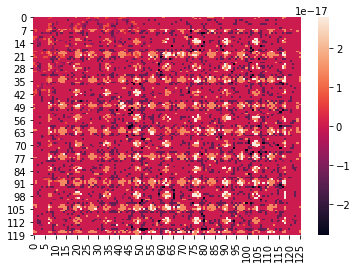

In [8]:
x = np.load("../tile_data/cameroon/{}/{}.npy".format(str(7), str(4)))

def validate_tiling(arr):
    arr = arr
    preds = tile_images(arr, None)
    preds_stacked = []
    preds = np.stack(preds)
    preds = preds[:, 0, 1:-1, 1:-1, 0]
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    print(stacked.shape)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

x1 = validate_tiling(x)
sns.heatmap(x[0, 1:-1, 1:-1, 0] - x1) 

In [9]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    

In [10]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

In [11]:
from time import sleep
all_preds = []
for row in tnrange(7,8):
    for column in range(3, 5):
        x = np.load("../tile_data/cameroon/{}/{}.npy".format(str(row), str(column)))
        all_preds.append(x)
#all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 2)

In [12]:
idx = 0

1


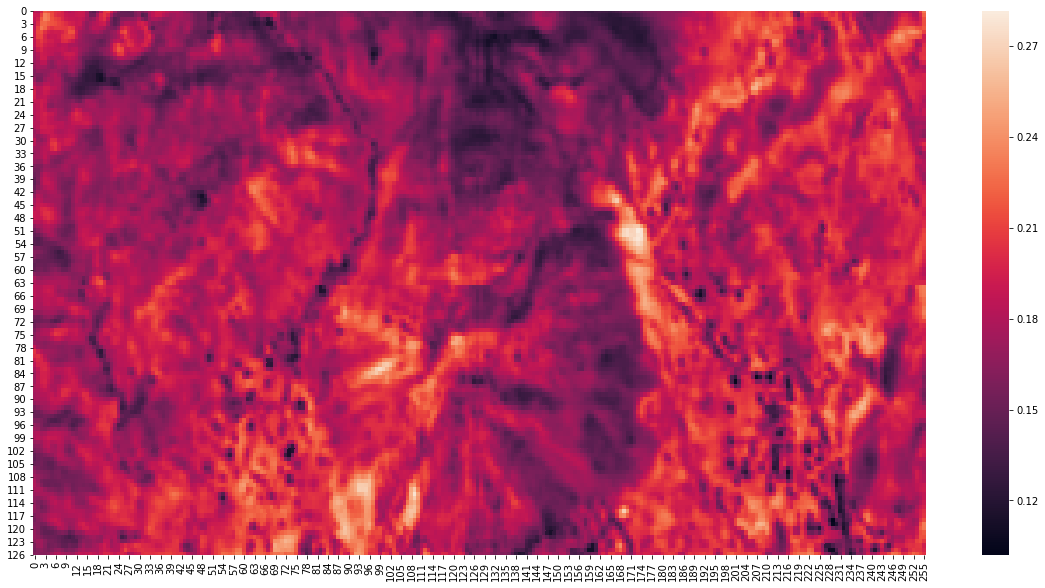

In [13]:
idx += 1
print(idx)
plt.figure(figsize=(20, 10))
#sns.heatmap(np.max(stacked[:, :, :, 4], 0) - np.min(stacked[:, :, :, 4], 0))
sns.heatmap(stacked[idx, :, :, 2])

In [14]:
from time import sleep
all_preds = []
for row in tnrange(0, 8):
    pred_i = [load_and_predict_folder(row, col) for col in range(0, 8)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked, overalpped, up, right = load_and_predict_folder(0, 0)

(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)
(14, 14)
(126, 126)


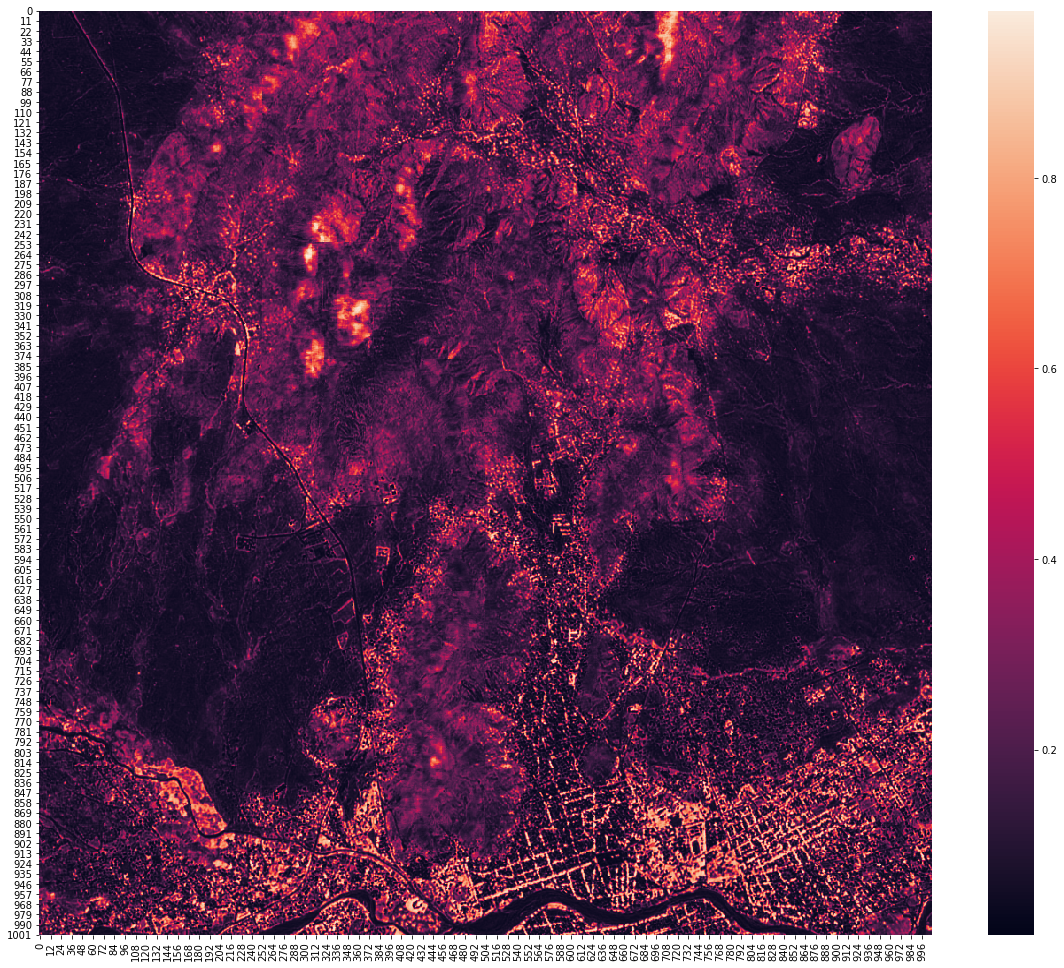

In [26]:
stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
sns.heatmap(stacked)
#plt.savefig('ghana.png', dpi = 300)

In [27]:
thresh = 0.4 # .4, .44 for makueni, 65, 75 for kochi
thresh_p = 0.55

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        l, r, u, d =  False, False, False, False
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            if cur_window[3, 2] > thresh and cur_window[4, 2] < thresh:
                hor_vert_neighbors = True
                r = True
            if cur_window[1, 2] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                l = True
            if cur_window[2, 3] > thresh and cur_window[2, 4] < thresh:
                hor_vert_neighbors = True
                d = True
            if cur_window[2, 1] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                u = True
        passes = False
        if r and not l:
            passes = True
        if l and not r:
            passes = True
        if d and not u:
            passes = True
        if u and not d:
            passes = True
        
        if passes:
            if r:
                if cur_window[1, 1] < thresh and cur_window[1, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
            
            if l:
                if cur_window[3, 1] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if u:
                if cur_window[1, 3] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if d:
                if cur_window[1, 1] < thresh and cur_window[3, 1] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            #n_offenders = 0
                
                #print(cur_window)

Adding a tree with: 0.48202841281890874
Adding a tree with: 0.40828368067741394
Adding a tree with: 0.4397068798542023
Adding a tree with: 0.42897864431142807
Adding a tree with: 0.4024174436926842
Adding a tree with: 0.5169207096099854
Adding a tree with: 0.4269792437553406
Adding a tree with: 0.432233214378357
Adding a tree with: 0.48480885028839116
Adding a tree with: 0.56
Adding a tree with: 0.43499741703271866
Adding a tree with: 0.5278681516647339
Adding a tree with: 0.44969703753789264
Adding a tree with: 0.49448470771312714
Adding a tree with: 0.56
Adding a tree with: 0.5152769684791565
Adding a tree with: 0.56
Adding a tree with: 0.4271543025970459
Adding a tree with: 0.42031340599060063
Adding a tree with: 0.43720121979713444
Adding a tree with: 0.423815389474233
Adding a tree with: 0.46866585314273834
Adding a tree with: 0.4358813315629959
Adding a tree with: 0.56
Adding a tree with: 0.4603456656138102
Adding a tree with: 0.5375441908836365
Adding a tree with: 0.423988160761

Adding a tree with: 0.42611198553017215
Adding a tree with: 0.44848021467526755
Adding a tree with: 0.4521983941396078
Adding a tree with: 0.4514123712267194
Adding a tree with: 0.56
Adding a tree with: 0.4366267442703247
Adding a tree with: 0.56
Adding a tree with: 0.47922725336892275
Adding a tree with: 0.40998633503913884
Adding a tree with: 0.44214618802070627
Adding a tree with: 0.5414561271667482
Adding a tree with: 0.56
Adding a tree with: 0.5035540819168092
Adding a tree with: 0.5155521035194397
Adding a tree with: 0.4154889242989677
Adding a tree with: 0.490912659962972
Adding a tree with: 0.40070752586637226
Adding a tree with: 0.4299309934888568
Adding a tree with: 0.4011064430077871
Adding a tree with: 0.4286532274314336
Adding a tree with: 0.56
Adding a tree with: 0.4426358001572746
Adding a tree with: 0.43073315819104513
Adding a tree with: 0.56
Adding a tree with: 0.4261855334043503
Adding a tree with: 0.56
Adding a tree with: 0.45599637031555174
Adding a tree with: 0.44

Adding a tree with: 0.41029886099008406
Adding a tree with: 0.4236287016134996
Adding a tree with: 0.4359161575635274
Adding a tree with: 0.42410440742969513
Adding a tree with: 0.56
Adding a tree with: 0.4050901383161545
Adding a tree with: 0.40827950835227966
Adding a tree with: 0.5121481716632843
Adding a tree with: 0.4381865203380585
Adding a tree with: 0.5455802151790032
Adding a tree with: 0.49472694442822385
Adding a tree with: 0.4108557059214666
Adding a tree with: 0.5141876729635092
Adding a tree with: 0.45012169480323794
Adding a tree with: 0.4812269032001496
Adding a tree with: 0.5484692958685068
Adding a tree with: 0.4201516310373943
Adding a tree with: 0.44339626232783
Adding a tree with: 0.4113537967205048
Adding a tree with: 0.440328687429428
Adding a tree with: 0.43097243209679925
Adding a tree with: 0.4699492077032725
Adding a tree with: 0.41811860295442427
Adding a tree with: 0.4410907924175263
Adding a tree with: 0.44420023606373704
Adding a tree with: 0.56
Adding a 

Adding a tree with: 0.448533594608307
Adding a tree with: 0.4749774277210236
Adding a tree with: 0.43998377238001146
Adding a tree with: 0.5069306130920139
Adding a tree with: 0.43873202800750744
Adding a tree with: 0.41065216703074325
Adding a tree with: 0.4408968289693197
Adding a tree with: 0.56
Adding a tree with: 0.41274422620024
Adding a tree with: 0.43833140603133613
Adding a tree with: 0.4193076640367508
Adding a tree with: 0.4385555535554886
Adding a tree with: 0.42528706576142994
Adding a tree with: 0.4406613324369703
Adding a tree with: 0.4434216693043709
Adding a tree with: 0.49918439611792564
Adding a tree with: 0.40639372169971466
Adding a tree with: 0.56
Adding a tree with: 0.42036761343479156
Adding a tree with: 0.4840945675969124
Adding a tree with: 0.44645371846854687
Adding a tree with: 0.4141174629330635
Adding a tree with: 0.43478900380432606
Adding a tree with: 0.56
Adding a tree with: 0.42877545101302017
Adding a tree with: 0.56
Adding a tree with: 0.409544795751

Adding a tree with: 0.5181993047396342
Adding a tree with: 0.56
Adding a tree with: 0.4871166547139486
Adding a tree with: 0.56
Adding a tree with: 0.4747629314661026
Adding a tree with: 0.4618969659010569
Adding a tree with: 0.4694188489363743
Adding a tree with: 0.4571691338832561
Adding a tree with: 0.4754251149984505
Adding a tree with: 0.4187883834044138
Adding a tree with: 0.56
Adding a tree with: 0.5072415073712667
Adding a tree with: 0.56
Adding a tree with: 0.457252779832253
Adding a tree with: 0.447287584726627
Adding a tree with: 0.56
Adding a tree with: 0.4138456170375529
Adding a tree with: 0.5303815245628357
Adding a tree with: 0.4193458534204042
Adding a tree with: 0.4059956096685849
Adding a tree with: 0.4381086459526648
Adding a tree with: 0.56
Adding a tree with: 0.414093459645907
Adding a tree with: 0.4431151564304644
Adding a tree with: 0.5339435316049135
Adding a tree with: 0.534476917523604
Adding a tree with: 0.5443295492575718
Adding a tree with: 0.56
Adding a t

Adding a tree with: 0.5427232757210732
Adding a tree with: 0.40897537767887115
Adding a tree with: 0.41257388591766364
Adding a tree with: 0.45169898867607117
Adding a tree with: 0.4593654374281565
Adding a tree with: 0.48859870433807373
Adding a tree with: 0.4589568078517914
Adding a tree with: 0.4343660275141398
Adding a tree with: 0.40821152925491333
Adding a tree with: 0.41070719559987384
Adding a tree with: 0.5480063557624817
Adding a tree with: 0.41776143420826306
Adding a tree with: 0.56
Adding a tree with: 0.47894901037216187
Adding a tree with: 0.410889208316803
Adding a tree with: 0.56
Adding a tree with: 0.5173338254292805
Adding a tree with: 0.56
Adding a tree with: 0.42176283597946174
Adding a tree with: 0.56
Adding a tree with: 0.5258603890736897
Adding a tree with: 0.4527620851993561
Adding a tree with: 0.5093084812164307
Adding a tree with: 0.56
Adding a tree with: 0.4761173725128174
Adding a tree with: 0.4707449376583099
Adding a tree with: 0.5350791811943054
Adding a 

Adding a tree with: 0.48741910109917325
Adding a tree with: 0.4806184321641922
Adding a tree with: 0.4014754997832435
Adding a tree with: 0.46863792701201
Adding a tree with: 0.5054366418293544
Adding a tree with: 0.4923996776342392
Adding a tree with: 0.56
Adding a tree with: 0.4398893735238484
Adding a tree with: 0.4950902064641316
Adding a tree with: 0.45684657778058735
Adding a tree with: 0.5149220994540624
Adding a tree with: 0.4187005162239074
Adding a tree with: 0.40799036820729573
Adding a tree with: 0.56
Adding a tree with: 0.4047711491584778
Adding a tree with: 0.4790659348169962
Adding a tree with: 0.45845460891723633
Adding a tree with: 0.44778528809547424
Adding a tree with: 0.48449109196662904
Adding a tree with: 0.4540182203054428
Adding a tree with: 0.4086008753095355
Adding a tree with: 0.56
Adding a tree with: 0.4877786274467196
Adding a tree with: 0.56
Adding a tree with: 0.5472630006926401
Adding a tree with: 0.4289818831852504
Adding a tree with: 0.4666932281106710

Adding a tree with: 0.4884487986564636
Adding a tree with: 0.4969470053911209
Adding a tree with: 0.4091196656227112
Adding a tree with: 0.47582095861434937
Adding a tree with: 0.56
Adding a tree with: 0.45584126313527423
Adding a tree with: 0.56
Adding a tree with: 0.5028751939535141
Adding a tree with: 0.4864246845245361
Adding a tree with: 0.5416989326477051
Adding a tree with: 0.5100315113862355
Adding a tree with: 0.56
Adding a tree with: 0.4485285679499308
Adding a tree with: 0.41083927949269605
Adding a tree with: 0.43448956807454425
Adding a tree with: 0.5118881940841675
Adding a tree with: 0.5296773165464401
Adding a tree with: 0.4392060836156209
Adding a tree with: 0.40346825718879703
Adding a tree with: 0.43195074796676636
Adding a tree with: 0.42339083552360535
Adding a tree with: 0.5386846707417413
Adding a tree with: 0.4491601268450419
Adding a tree with: 0.43551710018744827
Adding a tree with: 0.4439374666947584
Adding a tree with: 0.4843665679295858
Adding a tree with: 

Adding a tree with: 0.40672217806180316
Adding a tree with: 0.4305674359202385
Adding a tree with: 0.43137992918491364
Adding a tree with: 0.4883288187640054
Adding a tree with: 0.4029688183218241
Adding a tree with: 0.4863826632499695
Adding a tree with: 0.56
Adding a tree with: 0.56
Adding a tree with: 0.42148882895708084
Adding a tree with: 0.40569476783275604
Adding a tree with: 0.48695725202560425
Adding a tree with: 0.56
Adding a tree with: 0.4444293677806854
Adding a tree with: 0.5186346285045147
Adding a tree with: 0.4575851857662201
Adding a tree with: 0.40392037481069565
Adding a tree with: 0.56
Adding a tree with: 0.4252736195921898
Adding a tree with: 0.56
Adding a tree with: 0.484922936984471
Adding a tree with: 0.4763525128364564
Adding a tree with: 0.56
Adding a tree with: 0.4062519456659045
Adding a tree with: 0.40440298191138674
Adding a tree with: 0.449936044216156
Adding a tree with: 0.44879727278436937
Adding a tree with: 0.461307908807482
Adding a tree with: 0.4497

Adding a tree with: 0.5331216646092279
Adding a tree with: 0.5082396864891052
Adding a tree with: 0.44665365985461636
Adding a tree with: 0.5412745816367014
Adding a tree with: 0.5014244889219602
Adding a tree with: 0.519282877445221
Adding a tree with: 0.45919698476791376
Adding a tree with: 0.42221356431643164
Adding a tree with: 0.5197139953573545
Adding a tree with: 0.4672397822141647
Adding a tree with: 0.437442110135005
Adding a tree with: 0.4021546500069755
Adding a tree with: 0.4238537825070894
Adding a tree with: 0.5242696007092793
Adding a tree with: 0.4626899178211505
Adding a tree with: 0.4032006621360779
Adding a tree with: 0.4543687452872595
Adding a tree with: 0.5072855995251583
Adding a tree with: 0.46524444222450245
Adding a tree with: 0.4052399545907974
Adding a tree with: 0.4267306281970097
Adding a tree with: 0.5082919505926278
Adding a tree with: 0.56
Adding a tree with: 0.4375918874373802
Adding a tree with: 0.49303420782089236
Adding a tree with: 0.42411377796759

Adding a tree with: 0.4050392284989357
Adding a tree with: 0.4623044303485325
Adding a tree with: 0.56
Adding a tree with: 0.4134906360081264
Adding a tree with: 0.4059508442878723
Adding a tree with: 0.47843192145228386
Adding a tree with: 0.56
Adding a tree with: 0.4349956150565829
Adding a tree with: 0.4013803402582804
Adding a tree with: 0.47308924368449623
Adding a tree with: 0.4526026137173176
Adding a tree with: 0.41090401155608036
Adding a tree with: 0.45678109782082693
Adding a tree with: 0.425428284066064
Adding a tree with: 0.4100390246936253
Adding a tree with: 0.4309422433376313
Adding a tree with: 0.56
Adding a tree with: 0.40211791793505347
Adding a tree with: 0.56
Adding a tree with: 0.5371300024645669
Adding a tree with: 0.41438111662864685
Adding a tree with: 0.5100125830907088
Adding a tree with: 0.543885757525762
Adding a tree with: 0.49639832121985294
Adding a tree with: 0.5021259983380636
Adding a tree with: 0.4133716438497816
Adding a tree with: 0.456418499350547

Adding a tree with: 0.5163540206849575
Adding a tree with: 0.56
Adding a tree with: 0.44732251204550266
Adding a tree with: 0.47544485330581665
Adding a tree with: 0.56
Adding a tree with: 0.5159996577671597
Adding a tree with: 0.5029343850910664
Adding a tree with: 0.48238931223750114
Adding a tree with: 0.40128934755921364
Adding a tree with: 0.56
Adding a tree with: 0.43584854687963215
Adding a tree with: 0.41400772333145147
Adding a tree with: 0.42436135666710995
Adding a tree with: 0.56
Adding a tree with: 0.47699529145445146
Adding a tree with: 0.47195059912545345
Adding a tree with: 0.5149024831397193
Adding a tree with: 0.5368266361100335
Adding a tree with: 0.4140737354755402
Adding a tree with: 0.47657333016395576
Adding a tree with: 0.56
Adding a tree with: 0.4811416140624456
Adding a tree with: 0.4017692037991115
Adding a tree with: 0.4733142107725144
Adding a tree with: 0.5479995523180282
Adding a tree with: 0.56
Adding a tree with: 0.4202890793482463
Adding a tree with: 0

Adding a tree with: 0.4210945619986608
Adding a tree with: 0.4123952755561242
Adding a tree with: 0.56
Adding a tree with: 0.5149074792861938
Adding a tree with: 0.5223228732744853
Adding a tree with: 0.5426549407152029
Adding a tree with: 0.5327806931275587
Adding a tree with: 0.5154701150380648
Adding a tree with: 0.45757144918808557
Adding a tree with: 0.56
Adding a tree with: 0.44464072585105885
Adding a tree with: 0.43869839509328207
Adding a tree with: 0.4100311788228841
Adding a tree with: 0.5315484523773193
Adding a tree with: 0.5239611222193792
Adding a tree with: 0.4216655492782593
Adding a tree with: 0.4826691001653672
Adding a tree with: 0.46857669949531555
Adding a tree with: 0.5339048229731045
Adding a tree with: 0.5349197728293282
Adding a tree with: 0.45905008682837845
Adding a tree with: 0.5208155289292336
Adding a tree with: 0.44185712704291713
Adding a tree with: 0.5478859345118205
Adding a tree with: 0.4728578080733617
Adding a tree with: 0.40504613518714905
Adding 

Adding a tree with: 0.49379765987396235
Adding a tree with: 0.4436109002147402
Adding a tree with: 0.47349522511164355
Adding a tree with: 0.4258925063269479
Adding a tree with: 0.4427568097909292
Adding a tree with: 0.5460860473769052
Adding a tree with: 0.56
Adding a tree with: 0.5159783703940255
Adding a tree with: 0.56
Adding a tree with: 0.5114399705614363
Adding a tree with: 0.45781757576125015
Adding a tree with: 0.5341583371162415
Adding a tree with: 0.56
Adding a tree with: 0.4278780102729798
Adding a tree with: 0.49161971041134434
Adding a tree with: 0.5420504127229963
Adding a tree with: 0.44245434658867977
Adding a tree with: 0.4188835408006395
Adding a tree with: 0.5202366156237466
Adding a tree with: 0.56
Adding a tree with: 0.49196239454405655
Adding a tree with: 0.541784721116225
Adding a tree with: 0.46321810667331403
Adding a tree with: 0.4134450746434076
Adding a tree with: 0.5035255436713879
Adding a tree with: 0.520744243493447
Adding a tree with: 0.56
Adding a tre

Adding a tree with: 0.42249323853424614
Adding a tree with: 0.46878361701965326
Adding a tree with: 0.4337707482851467
Adding a tree with: 0.43473572603293825
Adding a tree with: 0.5187746559580168
Adding a tree with: 0.45250272750854503
Adding a tree with: 0.56
Adding a tree with: 0.4297688397077413
Adding a tree with: 0.56
Adding a tree with: 0.4076380317027751
Adding a tree with: 0.404348272543687
Adding a tree with: 0.4004630882006424
Adding a tree with: 0.42402046670516336
Adding a tree with: 0.5484247377940586
Adding a tree with: 0.45478712595426113
Adding a tree with: 0.4115310112635294
Adding a tree with: 0.5303044204528514
Adding a tree with: 0.44783012225077695
Adding a tree with: 0.48708650699028594
Adding a tree with: 0.56
Adding a tree with: 0.40383233932348395
Adding a tree with: 0.5326693654060363
Adding a tree with: 0.56
Adding a tree with: 0.4086724817752838
Adding a tree with: 0.56
Adding a tree with: 0.5012442469596863
Adding a tree with: 0.5124504069487253
Adding a 

Adding a tree with: 0.4347303991134349
Adding a tree with: 0.496347200870514
Adding a tree with: 0.5380155489994929
Adding a tree with: 0.4245830774307251
Adding a tree with: 0.56
Adding a tree with: 0.4684240380922953
Adding a tree with: 0.4365121355423561
Adding a tree with: 0.43563770330869234
Adding a tree with: 0.46342783937087434
Adding a tree with: 0.4170806209246317
Adding a tree with: 0.5292690442158626
Adding a tree with: 0.56
Adding a tree with: 0.47026266043002796
Adding a tree with: 0.4626354376475017
Adding a tree with: 0.4845548669497172
Adding a tree with: 0.40421311060587567
Adding a tree with: 0.4135545253753663
Adding a tree with: 0.4087250645344073
Adding a tree with: 0.56
Adding a tree with: 0.43731912741294277
Adding a tree with: 0.515599391857783
Adding a tree with: 0.48974692821502697
Adding a tree with: 0.5210323214530945
Adding a tree with: 0.4263625190808223
Adding a tree with: 0.5066024890312782
Adding a tree with: 0.5084081154603225
Adding a tree with: 0.56

Adding a tree with: 0.56
Adding a tree with: 0.4431665922914233
Adding a tree with: 0.4358709216117859
Adding a tree with: 0.5031799461160388
Adding a tree with: 0.44909243924277176
Adding a tree with: 0.519057422876358
Adding a tree with: 0.5414344540664129
Adding a tree with: 0.5467624068260193
Adding a tree with: 0.48056651864733024
Adding a tree with: 0.56
Adding a tree with: 0.446733900478908
Adding a tree with: 0.42100534041722615
Adding a tree with: 0.4011053911277227
Adding a tree with: 0.4112141004630498
Adding a tree with: 0.4088558384350368
Adding a tree with: 0.44452154636383057
Adding a tree with: 0.5366712808609009
Adding a tree with: 0.538709214755467
Adding a tree with: 0.44538630545139324
Adding a tree with: 0.43906028320391977
Adding a tree with: 0.4373578887719374
Adding a tree with: 0.40368881608758655
Adding a tree with: 0.41149255846227917
Adding a tree with: 0.4397456645965576
Adding a tree with: 0.5123454538675454
Adding a tree with: 0.41604465475449187
Adding a

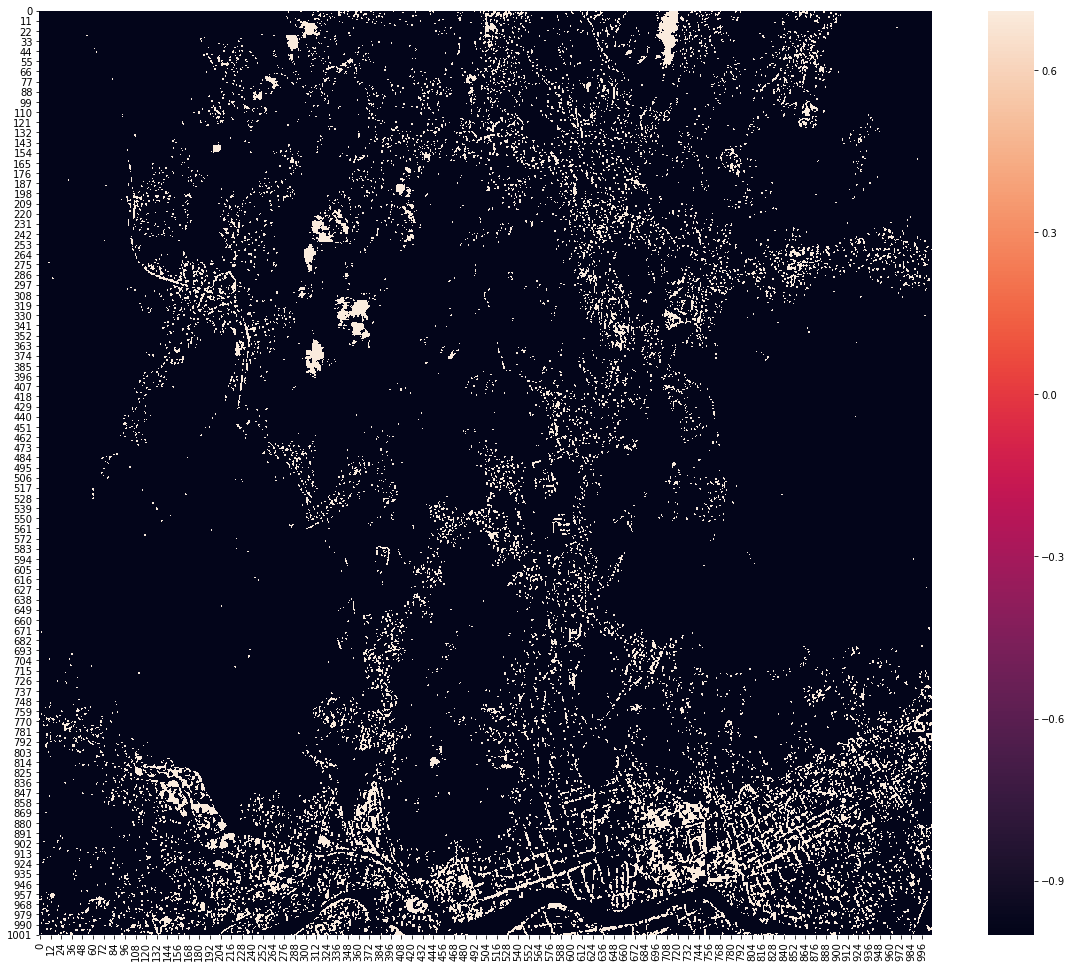

In [28]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
stacked[np.where(stacked > thresh_p)] = 1.
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 0.71
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

In [29]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (13.316919, 2.581680) # niger
coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # west mamprusi, ghana
#coords = (10.097017, -2.439068) #uppere west
#coords = (7.398111, -1.269223) # cocoa
#coords = (7.702058, -0.709011) # brong ahafo bono east
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (-20.147320, -40.837770) # ESPERITO SANTO BR 2
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu-large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (4.179529, -74.889171) # , colombia
#coords = (-1.648663, 30.112521) #rwanda
#coords = (11.574298, -12.492513) # guinea
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.727334, -90.015579) # elsalvador imposible
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (12.398014, -86.963042) # Nicaragua


coords = (coords[1], coords[0])
#bl = bounding_box(coords, (6*1260)+0, (6*1260)-0, expansion = 0) # -85, +135 el salv
#coords = (bl[0][0], bl[0][1])
point = bounding_box(coords, (8*1260)+0, (8*1260)-0, expansion = 0) # -85, +135 el salv
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

[10080.0, 10080.0]


In [30]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/cameroon.tif', 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

# Cloud optimized Geotiff

In [178]:
!gdal_translate ../../ce-hosting/includes/cameroon.tif cameroon.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro cameroon.tif 2 4 8 16 32
#!gsutil cp niger.tif gs://restoration-hosting/niger.tif

Input file size is 2520, 2520
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


# Half-hectare tree density Geotiff

In [179]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.7)
summed += 0.1

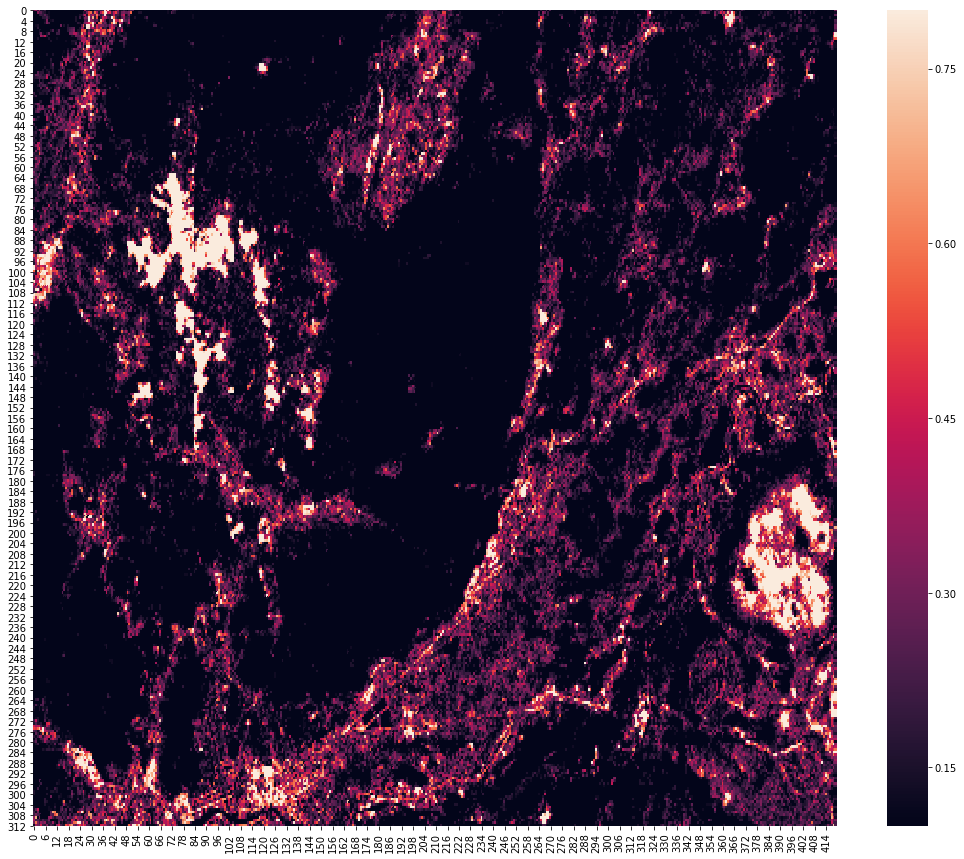

In [180]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)

In [181]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/cameroon1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()